In [160]:
import torch
import torch.nn as nn 
from torchvision import datasets, transforms
import torch.optim as optim 
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.utils.data.dataloader import default_collate
from vector_quantize_pytorch import VectorQuantize

In [2]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [3]:
# Define the transform to normalize the data
base_transform = transforms.Compose([
    transforms.ToTensor()
])

# Download and load the MNIST dataset
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=base_transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=base_transform)

# Create data loaders
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True, collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)))
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=1000, shuffle=False)

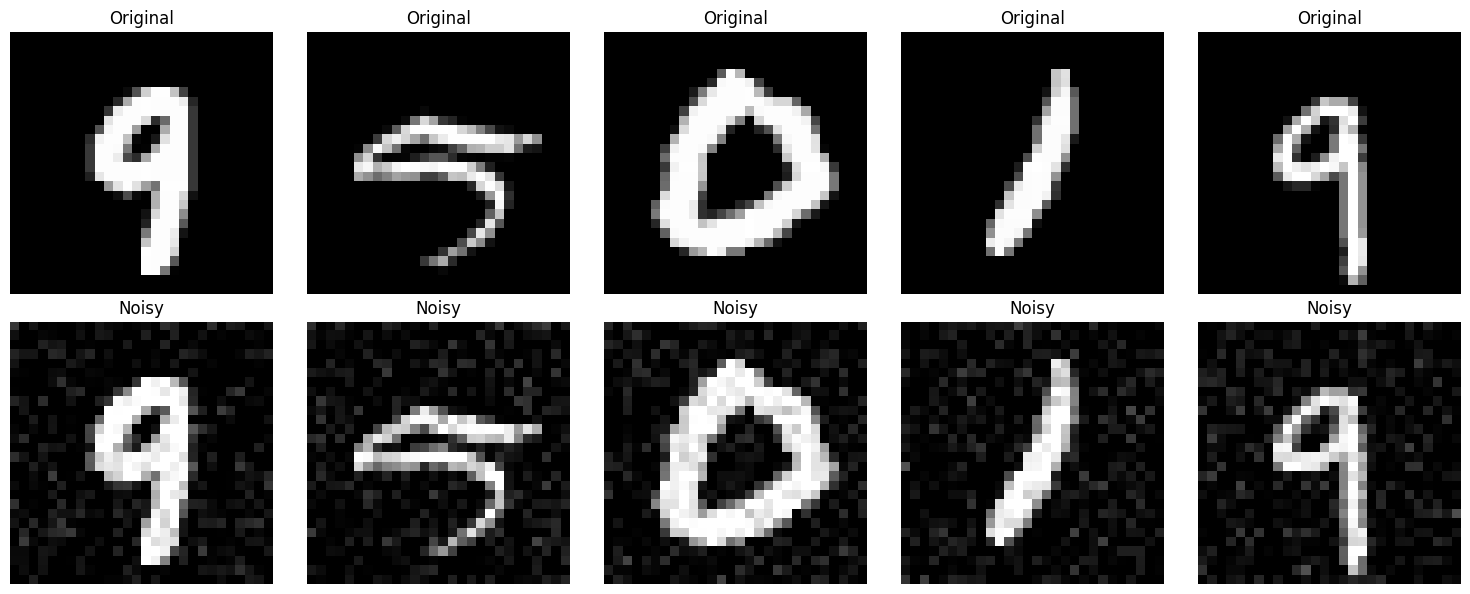

In [4]:
class NoisyDataset(torch.utils.data.Dataset):
    def __init__(self, original_dataset, noise_factor=0.1):
        self.original_dataset = original_dataset
        self.noise_factor = noise_factor

    def __getitem__(self, index):
        img, label = self.original_dataset[index]
        noise = torch.randn_like(img) * self.noise_factor
        noisy_img = img + noise
        noisy_img = torch.clamp(noisy_img, 0., 1.)
        return noisy_img, img, label  # Return noisy image and original image

    def __len__(self):
        return len(self.original_dataset)

mnist_train_noisy = NoisyDataset(mnist_train, noise_factor=0.1)
noisy_data_loader = torch.utils.data.DataLoader(mnist_train_noisy, batch_size=64, shuffle=True, collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)))

# Visualize original and noisy images
def visualize_noisy_images(dataloader, num_images=5):
    # Get a batch of images
    noisy_images, original_images, _ = next(iter(dataloader))
    
    # Create a figure with subplots
    fig, axes = plt.subplots(2, num_images, figsize=(15, 6))
    
    for i in range(num_images):
        # Display original image
        axes[0, i].imshow(original_images[i].squeeze().cpu(), cmap='gray')
        axes[0, i].set_title('Original')
        axes[0, i].axis('off')
        
        # Display noisy image
        axes[1, i].imshow(noisy_images[i].squeeze().cpu(), cmap='gray')
        axes[1, i].set_title('Noisy')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Call the function to visualize the images
visualize_noisy_images(noisy_data_loader)


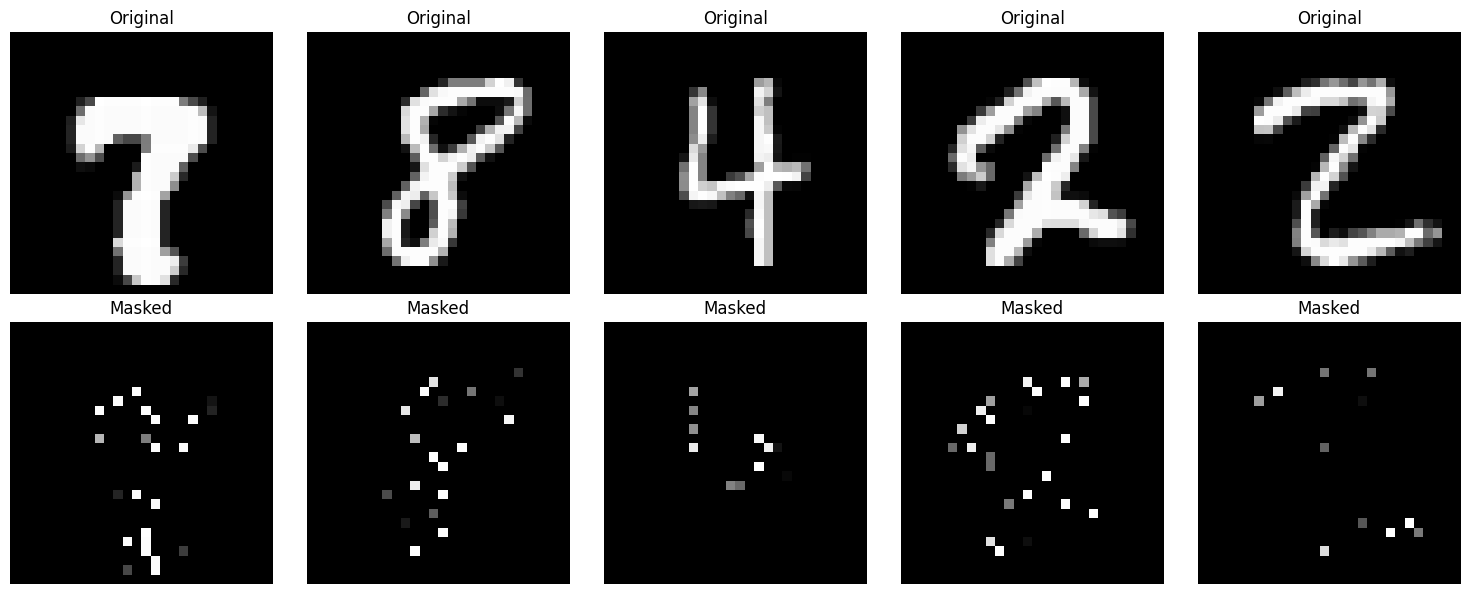

In [5]:
class MaskedDataset(torch.utils.data.Dataset):
    def __init__(self, original_dataset, mask_factor=0.1):
        self.original_dataset = original_dataset
        self.mask_factor = mask_factor

    def __getitem__(self, index):
        img, label = self.original_dataset[index]
        mask = torch.rand_like(img) < self.mask_factor
        masked_img = img * mask
        return masked_img, img, label  # Return masked image and original image
    
    def __len__(self):
        return len(self.original_dataset)

mnist_train_masked = MaskedDataset(mnist_train, mask_factor=0.1)
masked_data_loader = torch.utils.data.DataLoader(mnist_train_masked, batch_size=64, shuffle=True, collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)))

# Visualize original and masked images
def visualize_masked_images(dataloader, num_images=5):
    # Get a batch of images
    masked_images, original_images, _ = next(iter(dataloader))
    
    # Create a figure with subplots
    fig, axes = plt.subplots(2, num_images, figsize=(15, 6))
    
    for i in range(num_images):
        # Display original image
        axes[0, i].imshow(original_images[i].squeeze().cpu(), cmap='gray')
        axes[0, i].set_title('Original')
        axes[0, i].axis('off')
        
        # Display masked image
        axes[1, i].imshow(masked_images[i].squeeze().cpu(), cmap='gray')
        axes[1, i].set_title('Masked')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_masked_images(masked_data_loader)

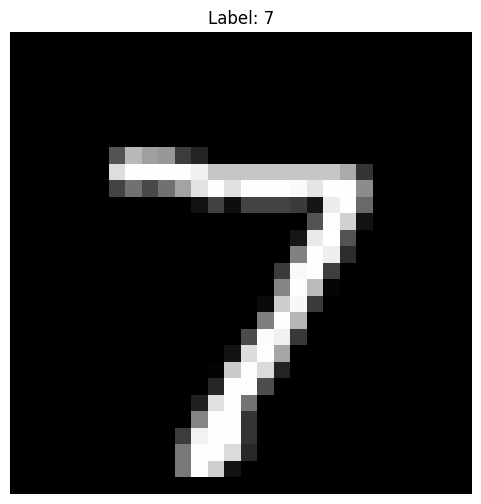

In [72]:
# Get a batch of training data
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Display the first image in the batch
plt.figure(figsize=(6, 6))
plt.imshow(images[0].squeeze(), cmap='gray')
plt.title(f'Label: {labels[0].item()}')
plt.axis('off')
plt.show()

In [6]:
class Autoencoder(nn.Module):
    def __init__(self, n_latent):
        super().__init__()

        self.encoder = nn.ModuleDict({
            'conv2d_layer1': nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(5,5), stride=2, padding=2),
            'relu1': nn.ReLU(),
            'conv2d_layer2': nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5,5), stride=2, padding=2),
            'relu2': nn.ReLU(),
            'conv2d_layer3': nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), stride=1, padding=1),
            'relu3': nn.ReLU(),
            'flatten': nn.Flatten(),
            'linear1': nn.Linear(in_features = 7*7*128, out_features=n_latent)
        })
        self.decoder = nn.ModuleDict({
            'linear1': nn.Linear(in_features=n_latent, out_features=7*7*128),
            'relu1': nn.ReLU(),
            'reshape': nn.Unflatten(1, (128, 7, 7)),
            'conv_transpose1': nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=(3,3), stride=1, padding=1),
            'relu2': nn.ReLU(),
            'conv_transpose2': nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=(5,5), stride=2, padding=2, output_padding=1),
            'relu3': nn.ReLU(),
            'conv_transpose3': nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=(5,5), stride=2, padding=2, output_padding=1)
        })

    def encode(self, x):
        for layer in self.encoder.values():
            x = layer(x)
        return x 
    
    def decode(self, x):
        for layer in self.decoder.values():
            x = layer(x)
        return x 
    
    def forward(self, x):
        # Encoder
        encoded = self.encode(x)
        decoded = self.decode(encoded)
        
        return decoded, encoded

In [6]:
model = Autoencoder(n_latent=10).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3)

epochs = 20
for epoch in range(epochs):
    running_loss = 0
    for i, (data, _) in enumerate(train_loader):
        images = data
        
        # zero grad
        optimizer.zero_grad()

        # forward 
        outputs, _ = model(images)

        # loss 
        loss = loss_fn(outputs, images)

        # backward 
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f"Epoch {epoch + 1}/{epochs} - loss: {running_loss/i}")


print("Training finished!")

# Save the model
torch.save(model.state_dict(), 'autoencoder_model.pth')
print("Model saved!")

# Need to fix this tomorrow...need to understand the outputs from conv layers 

KeyboardInterrupt: 

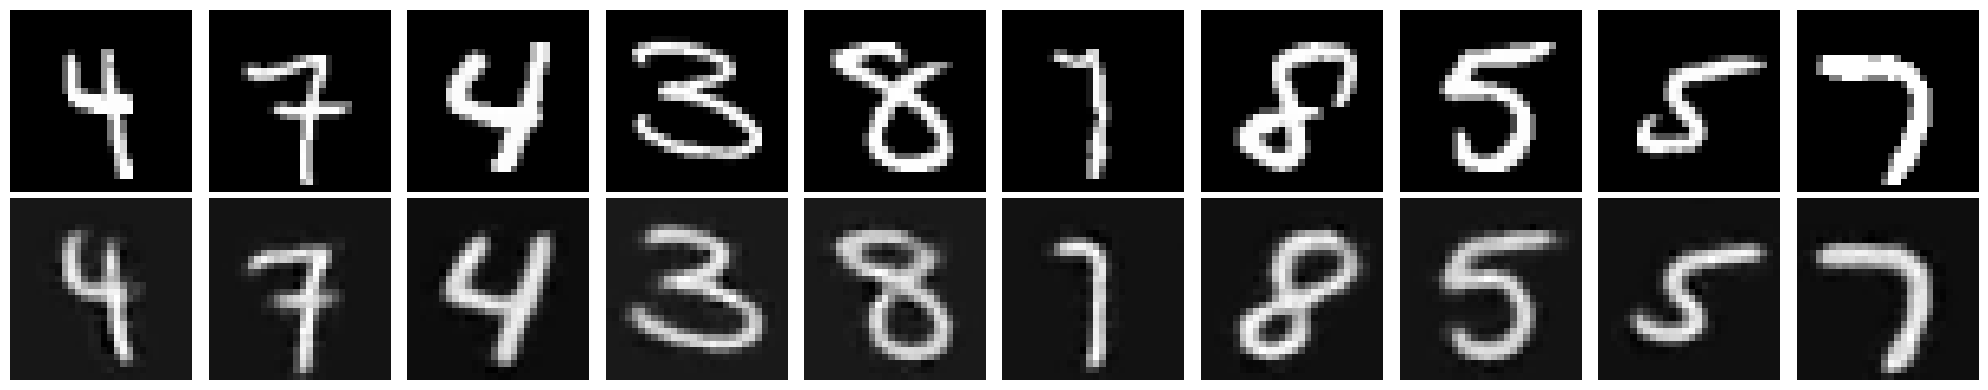

In [112]:
model.eval()
with torch.no_grad():
    # Get a batch of test images
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=base_transform)
    test_loader = DataLoader(test_dataset, batch_size=10, shuffle=True)
    test_images, _ = next(iter(test_loader))
    test_images = test_images.to(device)
    
    # Reconstruct images
    reconstructed = model(test_images)
    
    # Plot original and reconstructed images
    fig, axes = plt.subplots(2, 10, figsize=(20, 4))
    for i in range(10):
        axes[0, i].imshow(test_images[i].cpu().squeeze(), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(reconstructed[i].cpu().squeeze(), cmap='gray')
        axes[1, i].axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
# Add different constraints - denoising, masking, etc.

In [138]:
# Denoising autoencoder 

model = Autoencoder(n_latent=10).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3)

epochs = 20

for epoch in range(epochs):
    running_loss = 0
    for i, (noisy_images, images, _) in enumerate(noisy_data_loader):
        
        
        # zero grad
        optimizer.zero_grad()

        # forward 
        outputs = model(noisy_images)

        # loss 
        loss = loss_fn(outputs, images)

        # backward 
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f"Epoch {epoch + 1}/{epochs} - loss: {running_loss/i}")


# Save the model
torch.save(model.state_dict(), 'denoising_autoencoder_model.pth')
print("Model saved!")

Epoch 1/20 - loss: 0.025183546365802292
Epoch 2/20 - loss: 0.01544310739651529
Epoch 3/20 - loss: 0.013910546183204447
Epoch 4/20 - loss: 0.01306245722604186
Epoch 5/20 - loss: 0.01245121396342521
Epoch 6/20 - loss: 0.011997941042532153
Epoch 7/20 - loss: 0.011665090868843913
Epoch 8/20 - loss: 0.011385016386837499
Epoch 9/20 - loss: 0.011155558346493394
Epoch 10/20 - loss: 0.010943316470875366
Epoch 11/20 - loss: 0.010781846819256643
Epoch 12/20 - loss: 0.01062651650071653
Epoch 13/20 - loss: 0.010499147261943164
Epoch 14/20 - loss: 0.010375753242876321
Epoch 15/20 - loss: 0.010269431355076354
Epoch 16/20 - loss: 0.010176961161613688
Epoch 17/20 - loss: 0.010066335459250715
Epoch 18/20 - loss: 0.009984170943458853
Epoch 19/20 - loss: 0.009941965721253398
Epoch 20/20 - loss: 0.009855084259385043
Model saved!


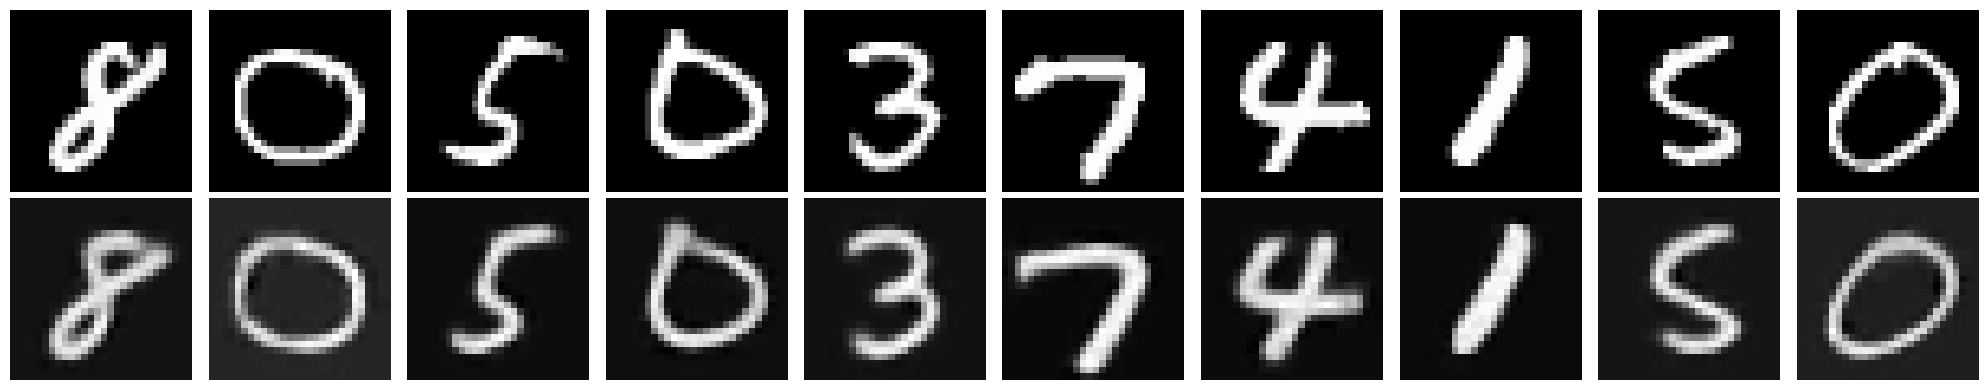

In [121]:
model.eval()
with torch.no_grad():
    # Get a batch of test images
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=base_transform)
    test_loader = DataLoader(test_dataset, batch_size=10, shuffle=True)
    test_images, _ = next(iter(test_loader))
    test_images = test_images.to(device)
    
    # Reconstruct images
    reconstructed = model(test_images)
    
    # Plot original and reconstructed images
    fig, axes = plt.subplots(2, 10, figsize=(20, 4))
    for i in range(10):
        axes[0, i].imshow(test_images[i].cpu().squeeze(), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(reconstructed[i].cpu().squeeze(), cmap='gray')
        axes[1, i].axis('off')
    plt.tight_layout()
    plt.show()

In [127]:
# Masked autoencoder

model = Autoencoder(n_latent=10).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3)

epochs = 20

for epoch in range(epochs):
    running_loss = 0
    for i, (masked_images, images, _) in enumerate(masked_data_loader):
        
        # zero grad
        optimizer.zero_grad()

        # forward 
        outputs = model(masked_images)

        # loss 
        loss = loss_fn(outputs, images)

        # backward 
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f"Epoch {epoch + 1}/{epochs} - loss: {running_loss/i}")

# Save the model
torch.save(model.state_dict(), 'masked_autoencoder_model.pth')
print("Model saved!")

Epoch 1/20 - loss: 0.04689348441734512
Epoch 2/20 - loss: 0.03638864301041707
Epoch 3/20 - loss: 0.03488212856667846
Epoch 4/20 - loss: 0.03411217683502806
Epoch 5/20 - loss: 0.03357219095108285
Epoch 6/20 - loss: 0.033136234319547195
Epoch 7/20 - loss: 0.03282915539999782
Epoch 8/20 - loss: 0.03260011274641898
Epoch 9/20 - loss: 0.03241932691694133
Epoch 10/20 - loss: 0.03218647958502062
Epoch 11/20 - loss: 0.03200105324451163
Epoch 12/20 - loss: 0.03192282184807379
Epoch 13/20 - loss: 0.031809535915212926
Epoch 14/20 - loss: 0.031722063655898435
Epoch 15/20 - loss: 0.031591419748794945
Epoch 16/20 - loss: 0.03149842881978258
Epoch 17/20 - loss: 0.031483635968322946
Epoch 18/20 - loss: 0.03130722346664938
Epoch 19/20 - loss: 0.03129794844202578
Epoch 20/20 - loss: 0.031220538903469083
Model saved!


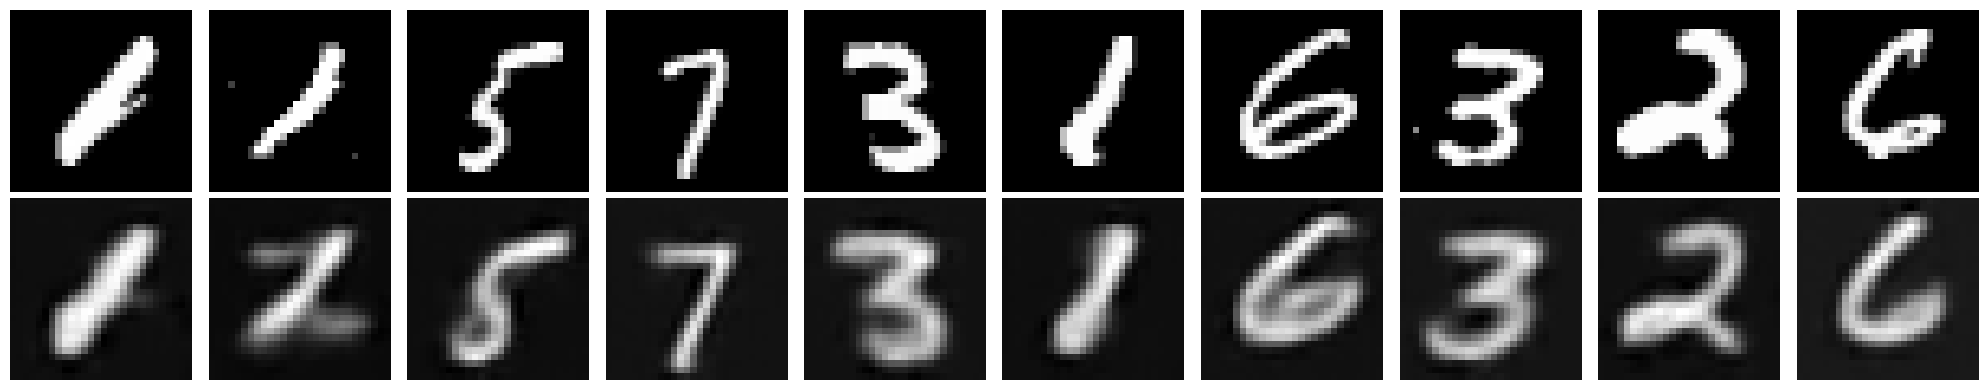

In [131]:
model.eval()
with torch.no_grad():
    # Get a batch of test images
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=base_transform)
    test_loader = DataLoader(test_dataset, batch_size=10, shuffle=True)
    test_images, _ = next(iter(test_loader))
    test_images = test_images.to(device)
    
    # Reconstruct images
    reconstructed = model(test_images)
    
    # Plot original and reconstructed images
    fig, axes = plt.subplots(2, 10, figsize=(20, 4))
    for i in range(10):
        axes[0, i].imshow(test_images[i].cpu().squeeze(), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(reconstructed[i].cpu().squeeze(), cmap='gray')
        axes[1, i].axis('off')
    plt.tight_layout()
    plt.show()

In [52]:
# Implement Sparse autoencoder

class SparseAutoencoder(Autoencoder):
    def __init__(self, n_latent, pretrained_weights=None):
        super().__init__(n_latent)

        if pretrained_weights:
            self.load_state_dict(pretrained_weights, strict=False)
            
        self.mse = nn.MSELoss() 

    
    def forward(self, x):
        return super().forward(x) # return reconstruction and latent label

    def loss(self, x, recon_x, lambda_=1e-5):
        return self.mse(x, recon_x) #+ lambda_*torch.norm(torch.cat([p.view(-1) for p in model.parameters()]), 1)


In [53]:
# Sparse autoencoder

model = SparseAutoencoder(n_latent=10).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-3)

epochs = 20

for epoch in range(epochs):
    running_loss = 0
    for i, (images, _) in enumerate(train_loader):
        
        # zero grad
        optimizer.zero_grad()

        # forward 
        outputs, _ = model(images)

        # loss 
        loss = model.loss(outputs, images)

        # backward 
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f"Epoch {epoch + 1}/{epochs} - loss: {running_loss/i}")

# Save the model
torch.save(model.state_dict(), 'sparse_autoencoder_model.pth')
print("Model saved!")

Epoch 1/20 - loss: 0.022916694245278327
Epoch 2/20 - loss: 0.014897390007336595
Epoch 3/20 - loss: 0.01337731349716319
Epoch 4/20 - loss: 0.012475973460326327
Epoch 5/20 - loss: 0.011871074313415152
Epoch 6/20 - loss: 0.01141063956665064
Epoch 7/20 - loss: 0.011052706786764342
Epoch 8/20 - loss: 0.010794664057232081
Epoch 9/20 - loss: 0.01055427675365034
Epoch 10/20 - loss: 0.010356923133898188
Epoch 11/20 - loss: 0.01019071901401976
Epoch 12/20 - loss: 0.010057966970801831
Epoch 13/20 - loss: 0.009913901503226673
Epoch 14/20 - loss: 0.009800466866378563
Epoch 15/20 - loss: 0.009693629544212412
Epoch 16/20 - loss: 0.00960712285618931
Epoch 17/20 - loss: 0.009517719411552588
Epoch 18/20 - loss: 0.009432966941659486
Epoch 19/20 - loss: 0.009351363655064442
Epoch 20/20 - loss: 0.009288221120579901
Model saved!


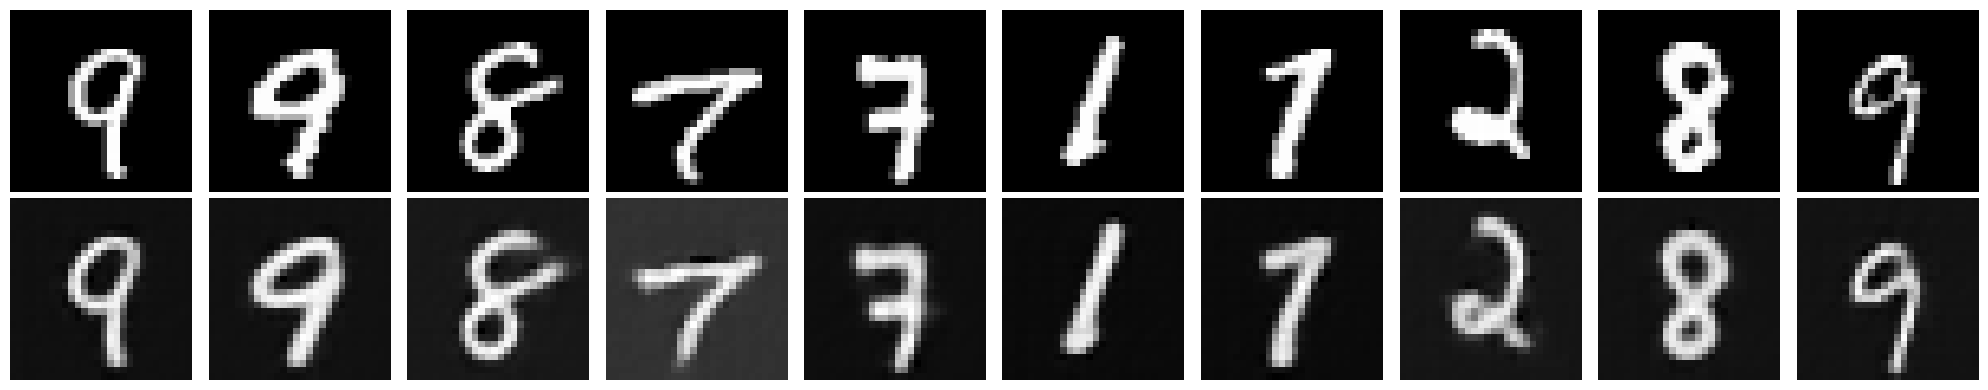

In [54]:
model.eval()
with torch.no_grad():
    # Get a batch of test images
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=base_transform)
    test_loader = DataLoader(test_dataset, batch_size=10, shuffle=True)
    test_images, _ = next(iter(test_loader))
    test_images = test_images.to(device)

    # Reconstruct images
    reconstructed, _ = model(test_images)
    
    # Plot original and reconstructed images
    fig, axes = plt.subplots(2, 10, figsize=(20, 4))
    for i in range(10):
        axes[0, i].imshow(test_images[i].cpu().squeeze(), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(reconstructed[i].cpu().squeeze(), cmap='gray')
        axes[1, i].axis('off')
    plt.tight_layout()
    plt.show()

In [8]:
class ConditionalAutoencoder(Autoencoder):
    def __init__(self, n_latent, n_y, pretrained_weights=None):
        super().__init__(n_latent)

        if pretrained_weights:
            self.load_state_dict(pretrained_weights, strict=False)

        # Adjust the latent space      
        self.encoder['linear1'] = nn.Linear(in_features=7*7*128, out_features=n_latent + n_y)
        self.decoder['linear1'] = nn.Linear(in_features=n_latent + n_y, out_features=7*7*128)

    def forward(self, x):
        return super().forward(x) # return reconstruction and latent label

ae_w = torch.load('autoencoder_model.pth', weights_only=True) 
model = ConditionalAutoencoder(n_latent=10, n_y=1, pretrained_weights=ae_w)

In [ ]:
# Conditional Autoencoder 

# Define new autoencoder with expanded latent - done

# Load weights from previous autoencoder for each layer - done 

# Retrain model - using one of the laten dimensions as the conditional variable (i.e. the label)

class ConditionalLoss(nn.Module):
    def __init__(self, lambda_=1):
        super().__init__()
        self.lambda_ = lambda_
        self.mse = nn.MSELoss()
        self.ce = nn.CrossEntropyLoss() 

    def forward(self, outputs, reconstruction, latent_labels, labels):
        
        loss = self.mse(outputs, reconstruction) + self.lambda_*torch.mean((latent_labels - labels)**2) # Need to one-hot encode vector rep and get the loss on this... 
    
        #+ torch.mean(latent_label[:, -1] - label)**2
        return loss


model = ConditionalAutoencoder(n_latent=10, n_y=1, pretrained_weights=ae_w).to(device)
loss_fn = ConditionalLoss() 
optimizer = optim.AdamW(model.parameters(), lr=1e-3)

In [21]:
epochs = 10

for epoch in range(epochs):
    running_loss = 0
    for i, (images, labels) in enumerate(train_loader):
        
        # zero grad
        optimizer.zero_grad()

        # forward 
        outputs, latent_labels = model(images)
        #print(outputs.shape, latent_labels[:, -1].shape)
        
        # loss 
        loss = loss_fn(outputs, images, latent_labels[:, -1], labels)
        # backward 

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f"Epoch {epoch + 1}/{epochs} - loss: {running_loss/i}")

# Save the model
torch.save(model.state_dict(), 'conditional_autoencoder_model.pth')
print("Model saved!")

Epoch 1/10 - loss: 0.16931085500830392
Epoch 2/10 - loss: 0.1579793406970473
Epoch 3/10 - loss: 0.1483949897065361
Epoch 4/10 - loss: 0.1398082392502938
Epoch 5/10 - loss: 0.13266301354673654
Epoch 6/10 - loss: 0.12358929462563903
Epoch 7/10 - loss: 0.11561915927676915
Epoch 8/10 - loss: 0.11090366956216294
Epoch 9/10 - loss: 0.10820597929834301
Epoch 10/10 - loss: 0.10307299587060573
Model saved!


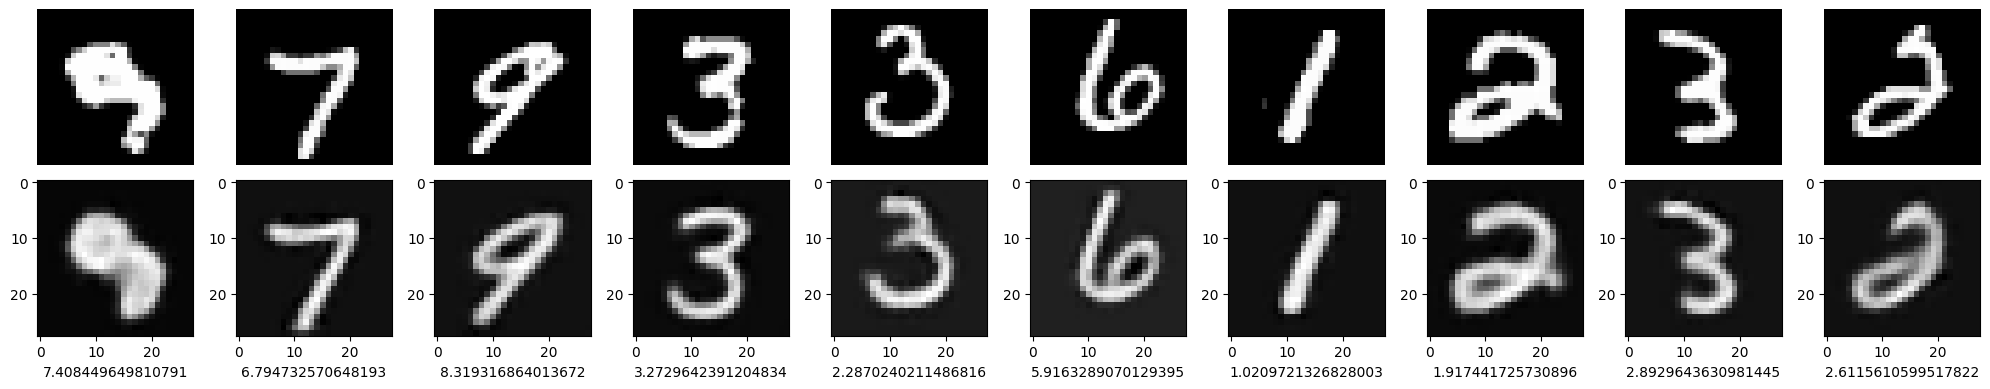

In [22]:
model.eval()
with torch.no_grad():
    # Get a batch of test images
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=base_transform)
    test_loader = DataLoader(test_dataset, batch_size=10, shuffle=True)
    test_images, _ = next(iter(test_loader))
    test_images = test_images.to(device)
    
    # Reconstruct images
    reconstructed_image, latents  = model(test_images)
    
    # Plot original and reconstructed images
    fig, axes = plt.subplots(2, 10, figsize=(20, 4))
    for i in range(10):
        axes[0, i].imshow(test_images[i].cpu().squeeze(), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(reconstructed_image[i].cpu().squeeze(), cmap='gray')
        #axes[1, i].axis('off')
        axes[1, i].set_xlabel(f"{latents[i,-1]}")
    plt.tight_layout()
    plt.show()


In [197]:
vq = VectorQuantize(
            dim = 10,
            codebook_size = 10, # codebook size
            decay = 0.8, # the exponential moving average decay, lower means the dictionary will change faster
            commitment_weight=1
)

x = torch.rand(100, 10)

q, _, _ = vq(x)
print(q.shape)

torch.Size([100, 10])


In [250]:
class VQAutoencoder(nn.Module):
    def __init__(self, n_latent):
        super().__init__()

        self.encoder = nn.ModuleDict({
            'conv2d_layer1': nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(5,5), stride=2, padding=2),
            'relu1': nn.ReLU(),
            'conv2d_layer2': nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5,5), stride=2, padding=2),
            'relu2': nn.ReLU(),
            'conv2d_layer3': nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), stride=1, padding=1),
            'relu3': nn.ReLU(),
            'flatten': nn.Flatten(),
            'linear1': nn.Linear(in_features = 7*7*128, out_features=n_latent)
        })

        self.vq = VectorQuantize(
            dim=10,
            codebook_size=10,
            commitment_weight=1.
        )

        self.decoder = nn.ModuleDict({
            'linear1': nn.Linear(in_features=n_latent, out_features=7*7*128),
            'relu1': nn.ReLU(),
            'reshape': nn.Unflatten(1, (128, 7, 7)),
            'conv_transpose1': nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=(3,3), stride=1, padding=1),
            'relu2': nn.ReLU(),
            'conv_transpose2': nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=(5,5), stride=2, padding=2, output_padding=1),
            'relu3': nn.ReLU(),
            'conv_transpose3': nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=(5,5), stride=2, padding=2, output_padding=1)
        })

    def encode(self, x):
        for layer in self.encoder.values():
            x = layer(x)
        return x 
    
    def quantize(self, x):
        q, _, vq_loss = self.vq(x)
        return q, vq_loss 
    
    def decode(self, x):
        for layer in self.decoder.values():
            x = layer(x)
        return x 
    
    def forward(self, x):
        # Encoder
        encoded = self.encode(x)
        q, vq_loss = self.quantize(encoded)
        decoded = self.decode(q)
        
        return decoded, q, vq_loss
    
    def loss(self, x, x_recon, vq_loss):
        return nn.MSELoss()(x, x_recon) + vq_loss

In [251]:
model = VQAutoencoder(n_latent=10).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-3)

epochs = 10

for epoch in range(epochs):
    running_loss = 0
    for i, (images, _) in enumerate(train_loader):
        
        # zero grad
        optimizer.zero_grad()

        # forward 
        outputs, _, vq_loss = model(images)

        # loss 
        loss = model.loss(outputs, images, vq_loss)

        # backward 
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f"Epoch {epoch + 1}/{epochs} - loss: {running_loss/i}")

# Save the model
torch.save(model.state_dict(), 'vq_autoencoder_model.pth')
print("Model saved!")

Epoch 1/10 - loss: 0.06023298819393333
Epoch 2/10 - loss: 0.05601380267672503
Epoch 3/10 - loss: 0.05569627741500815
Epoch 4/10 - loss: 0.055116271912224644
Epoch 5/10 - loss: 0.05484729306325078
Epoch 6/10 - loss: 0.05468790879594351
Epoch 7/10 - loss: 0.054422896263947994
Epoch 8/10 - loss: 0.05434410860056302
Epoch 9/10 - loss: 0.0546209095771501
Epoch 10/10 - loss: 0.05474460396514122
Model saved!


In [252]:
# Explore the quantised representation

In [ ]:
# Implement VAE

In [71]:
# Implement VQ-VAE

In [109]:
# FMAE 